In [1]:
import os
import sys
sys.path.append("..")
import prototypes
from primitives import *
from agent import DummyAgent

import nxsdk.api.n2a as nx
import numpy as np
from nxsdk.graph.monitor.probes import *

Here, we use the nodes framework to carry out a more advanced operation: taking an average firing-rate across multiple sources. To do this, we create several 'Tracker' nodes which estimate the proportion of reward spikes over the total received spikes at their inputs. If there are no inputs, they continue to fire at their learned rates. Then, these are averaged down using a node which samples from each of the sources equally through time.

In [2]:
#define constants & parameters
n_signals = 2
n_samples = 4
n_total = n_signals * n_samples
shape = (n_signals, n_samples)

learn_time = 1000
estimate_time = 1000
time = learn_time + estimate_time

seed = 796423

In [3]:
agent = DummyAgent(1, 1)
net = agent.network

We set up the source signals. Each port will fire with a chance proportional to the underlying signal's true firing rate parameter (each port is an independent Bernoulli sample). 

In [4]:
#signals which increase tracker firing
positive_signals = net.createSpikeGenProcess(numPorts=n_total)
#signals which decrease tracker firing
negative_signals = net.createSpikeGenProcess(numPorts=n_total)

In [5]:
#create random spiking following the true rate for each signal/sample
def create_spikes(psignals, nsignals, n_signals, n_samples, time):
    np.random.seed(seed)
    parameters = np.linspace(0,1,num=2+n_signals)[1:-1]
    
    for i in range(n_signals):
        for j in range(n_samples):
            x = np.random.rand(time+1)
            pt = ((x <= parameters[i])*np.arange(1,time+2)).tolist()
            nt = ((x > parameters[i])*np.arange(1,time+2)).tolist()
            
            psignals.addSpikes([j+n_samples*i], [pt])
            nsignals.addSpikes([j+n_samples*i], [nt])
            
    return parameters
    

In [6]:
#assign firing times following the parameters to the signal generators
parameters = create_spikes(positive_signals, negative_signals, n_signals, n_samples, learn_time)

Now, we create the computational nodes. Each tracker will learn from a single port from the positive/negative signals. Then, the average node will fire at the average over several of the trackers.

In [7]:
trackers = TrackerNode(net, shape)

In [9]:
averager = AveragePoolNode(net, shape, 1)

First, we connect one-to-one the source signals and the trackers.

In [8]:
positive_to_trackers = connect_one_to_one(positive_signals, trackers.get_inputs()[0], trackers.get_synproto())
negative_to_trackers = connect_one_to_one(negative_signals, trackers.get_inputs()[1], trackers.get_synproto())

Then, we connect one-to-one the tracked firing rates and average over them.

In [10]:
followers_to_average = connect_one_to_one(trackers.get_outputs(), averager.get_inputs(), averager.get_synproto())

In [11]:
output = averager.get_outputs()
output_spks = output.probe(nx.ProbeParameter.SPIKE)

In [12]:
net.run(time)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46475
INFO:DRV:      Host server up..............Done 0.17s
INFO:DRV:      Compiling Embedded snips....Done 0.41s
INFO:DRV:      Encoding axons/synapses.....Done 0.01s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599610100.5263515/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.02s
INFO:DRV:      Encoding probes.............Done 1.46ms
INFO:DRV:      Transferring probes.........Done 3.19ms
INFO:DRV:      Configuring registers.......Done 5.40ms
INFO:DRV:      Transferring spikes.........Done 0.05s
INFO:DRV:      Executing...................Done 0.15s
INFO:DRV:      Processing timeseries.......Done 4.30ms
INFO:DRV:  Executor: 2000 timesteps........Done 2.86s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


In [13]:
def plot_data(probe, parameters, avg_time=100):
    spikes = probe[0].data
    n_signals = spikes.shape[0]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    n_colors = len(colors)
    colormap = [colors[i % n_colors] for i in range(n_signals)]
    
    plt.figure()
    plt.xlabel("Time")
    plt.ylabel("Firing Rate & True Parameter")
    for i in range(n_signals):
        plt.plot(np.convolve(probe[0].data[i], np.ones(avg_time), mode='valid')/avg_time, color=colormap[i])
        plt.plot(np.arange(time), np.ones(time)*parameters[i], color=colormap[i])

Now, we can plot the final learned, average rate, and show that it approaches the parameter.

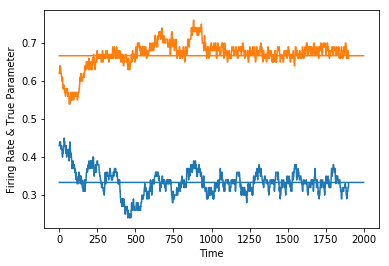

In [14]:
plot_data(output_spks, parameters)

Now we define the generic construction function and easily replicate the same experiment for different shapes/samples.

In [15]:
def create_and_test(n_signals, n_samples):
    n_total = n_signals * n_samples
    shape = (n_signals, n_samples)

    learn_time = 1000
    estimate_time = 1000
    time = learn_time + estimate_time

    seed = 796423
    
    agent = DummyAgent(1, 1)
    net = agent.network
    
    positive_signals = net.createSpikeGenProcess(numPorts=n_total)
    negative_signals = net.createSpikeGenProcess(numPorts=n_total)
    parameters = create_spikes(positive_signals, negative_signals, n_signals, n_samples, learn_time)
    
    trackers = TrackerNode(net, shape)
    averager = AveragePoolNode(net, shape, 1)
    
    positive_to_trackers = connect_one_to_one(positive_signals, trackers.get_inputs()[0], trackers.get_synproto())
    negative_to_trackers = connect_one_to_one(negative_signals, trackers.get_inputs()[1], trackers.get_synproto())
    trackers_to_average = connect_one_to_one(trackers.get_outputs(), averager.get_inputs(), averager.get_synproto())
    
    output = averager.get_outputs()
    output_spks = output.probe(nx.ProbeParameter.SPIKE)
    net.run(time)
    net.disconnect()
    
    return output_spks, parameters

In [16]:
output_4x4 = create_and_test(4,4)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:41339
INFO:DRV:      Host server up..............Done 0.20s
INFO:DRV:      Encoding axons/synapses.....Done 0.03s
INFO:DRV:      Compiling Embedded snips....Done 0.35s
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1599610105.5771866/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 2.02s
INFO:DRV:      Encoding probes.............Done 4.47ms
INFO:DRV:      Transferring probes.........Done 4.04ms
INFO:DRV:      Configuring registers.......Done 7.16ms
INFO:DRV:      Transferring spikes.........Done 0.12s
INFO:DRV:      Executing...................Done 0.15s
INFO:DRV:      Processing timeseries.......Done 8.76ms
INFO:DRV:  Executor: 2000 timesteps........Done 2.93s
INFO:HST:  chip=0 cpu=0 halted, status=0x0


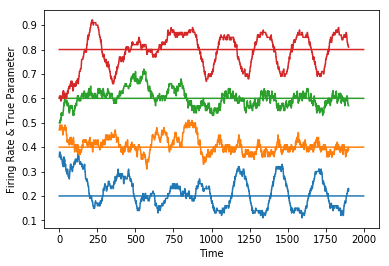

In [17]:
plot_data(output_4x4[0], output_4x4[1])